In [1]:
import numpy as np
import matplotlib.pyplot as plt
import typing

%matplotlib inline


В данной программе нужно написат решение задачи Коши методом Рунге-Кутты с помощью следующей таблицы Бутчера:

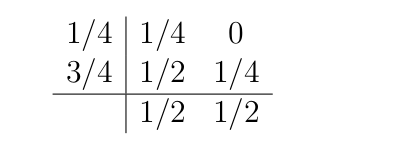

Проверим условия сходимости, чтобы определеить порядок точности:
$$b_1 + b_2 = 1$$
$$b_1c_1 + b_2c_2 = \frac{1}{2}$$
$$b_1c_1^2 + b_2c_2^2 = \frac{10}{32} \neq \frac{1}{3}$$
Значит, имеем второй порядок точности.

Реализуем метод Ньютона:

In [2]:
def newton_method(x0, f, gradf, max_iter=250, tol=1e-5):
    x = x0
    for i in range(max_iter):
        if np.isscalar(gradf(x)):
            dif = f(x) / gradf(x)
            if np.abs(dif) < tol:
                break
        else:
            dif = np.linalg.inv(gradf(x)) @ f(x)
            if np.linalg.norm(dif, ord=np.inf) < tol:
                break
        
        x -= dif
    
    return x

In [3]:
newton_method(2, lambda x: x*(x - 3), lambda x: 2*x - 3, 100, tol=1e-3)

3.00004577706569

Теперь реализуем метод для поиска численного решения:

In [4]:
def make_arange(segment, n):
    h = segment[1] / float(n)
    t = np.arange(n+1) * h
    return t

def butcher_method(segment, u0, f, gradf, n, tol=1e-5):
    u = np.empty(n+1, dtype=object)
    u[0] = u0
    h = segment[1] / float(n)
    t = make_arange(segment, n)
    
    k1 = None
    k2 = None
    
    def gen_f_k2(x, i):
        return x - f(t[i] + h, u[i] + h/2 * (k1+x))
    
    def gen_gradf_k2(x, i):
        I = None
        if np.isscalar(x):
            I = 1
        else:
            I = np.eye(x.shape[0])
        return I - h/2 * gradf(t[i] + h, u[i] + h/2 * (k1+x))
    
    for i in range(n):
        k1 = f(t[i], u[i])
        
        f_k2 = lambda x: gen_f_k2(x, i)
        gradf_k2 = lambda x: gen_gradf_k2(x, i)
        k2 = newton_method(u[i] + h/2 * k1, f_k2, gradf_k2, tol=tol)
        
        u[i+1] = u[i] + h/2 * (k1 + k2)
        
    return u
        

In [5]:
def Newton(x0, f, gradf, max_iter=250, tol=1e-5):
    x = x0
    
    for k in range(max_iter):
        if np.isscalar(gradf(x)):
            dif = f(x) / gradf(x)
            if np.abs(dif) < tol:
                break
        else:
            dif = np.linalg.inv(gradf(x)) @ f(x)
            if np.linalg.norm(dif, ord=np.inf) < tol:
                break
        
        x -= dif
    
    return x

def arange(segment, n):
    h = segment[1] / float(n)
    t = np.arange(n+1) * h
    return t

def Cauchy(segment, u0, f, gradf, n, tol=1e-5):
    u = np.empty(n+1, dtype=object)
    u[0] = u0
    h = segment[1] / float(n)
    t = arange(segment, n)
    
    k1 = None
    k2 = None
    
    def gen_f_k2(x, i):
        return x - f(t[i] + h, u[i] + h/2 * (k1+x))
    
    def gen_gradf_k2(x, i):
        I = None
        if np.isscalar(x):
            I = 1
        else:
            I = np.eye(x.shape[0])
        return I - h/2 * gradf(t[i] + h, u[i] + h/2 * (k1+x))
    
    for i in range(n):
        k1 = f(t[i], u[i])
        
        f_k2 = lambda x: gen_f_k2(x, i)
        gradf_k2 = lambda x: gen_gradf_k2(x, i)
        k2 = Newton(u[i] + h/2 * k1, f_k2, gradf_k2, tol=tol)
        
        u[i+1] = u[i] + h/2 * (k1 + k2)
        
    return u
        

Напишем функцию для графика, на котором изображено точное и численное решение

In [6]:
def plot(segment, my_sol, real_sol):
    t = make_arange(segment, my_sol.shape[0]-1)
    t1 = make_arange(segment, 10000)
    plt.figure(figsize=(16, 9))
    plt.scatter(t, my_sol, label="численное решение")
    plt.plot(t1, real_sol(t1), label="точное решение", color='r')
    plt.legend()
    plt.show()

Проверим решение на  $u_t = e^t$,  $u(0) = 0$

In [7]:
def f(t, u):
    return np.exp(t)

def gradf(t, u):
    return 0

segment = [0, 1]

my_sol = Cauchy(segment, 1, f, gradf, 10)

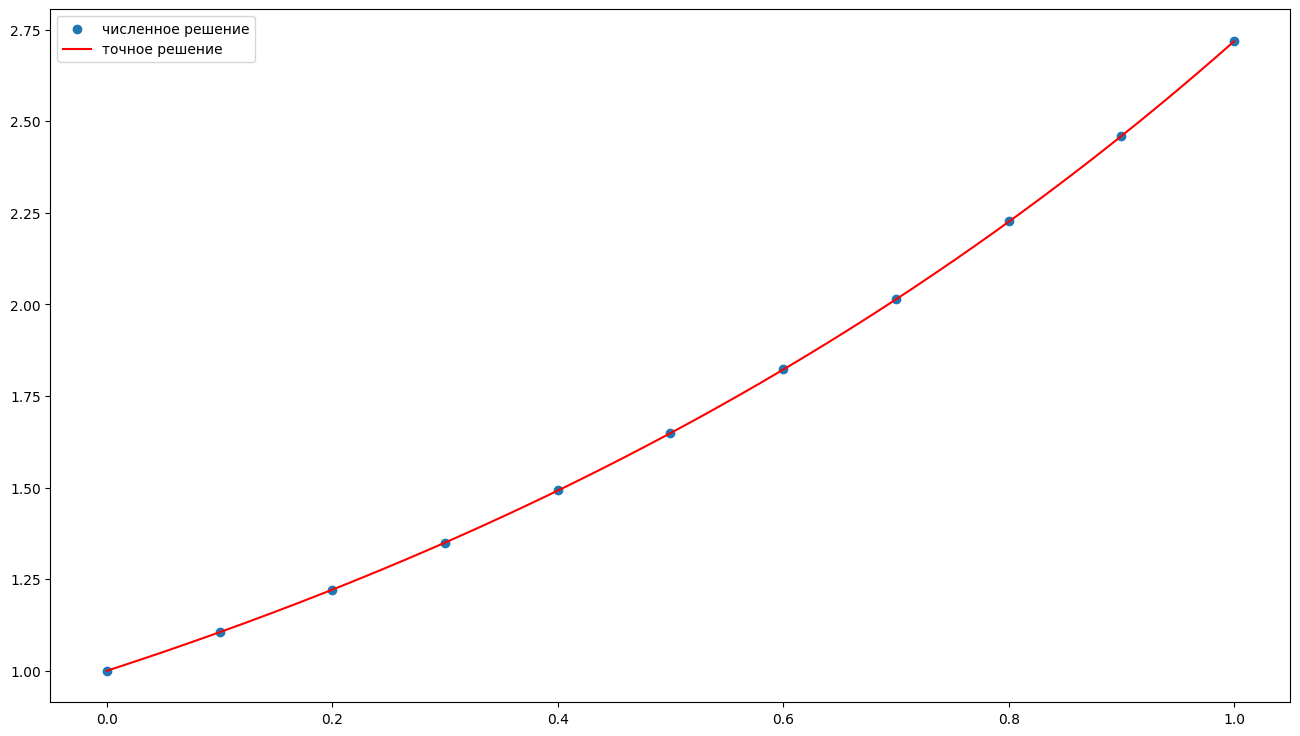

In [8]:
plot(segment, my_sol, np.exp)

$u_t = v$
$v_t = -u$
$u(0) = 0, v(0) = 1$

In [9]:
segment2 = [0, np.pi/2]

def f2(t, u):
    return np.array([u[1], -u[0]])

def gradf2(t, u):
    return np.array([[0,1], [-1,0]])

my_sol2 = Cauchy(segment2, np.array([0.,1.]), f2, gradf2, 15, tol=1e-5)
my_sin = np.array([my_sol2[i][0] for i in range(my_sol2.shape[0])])
my_cos = np.array([my_sol2[i][1] for i in range(my_sol2.shape[0])])

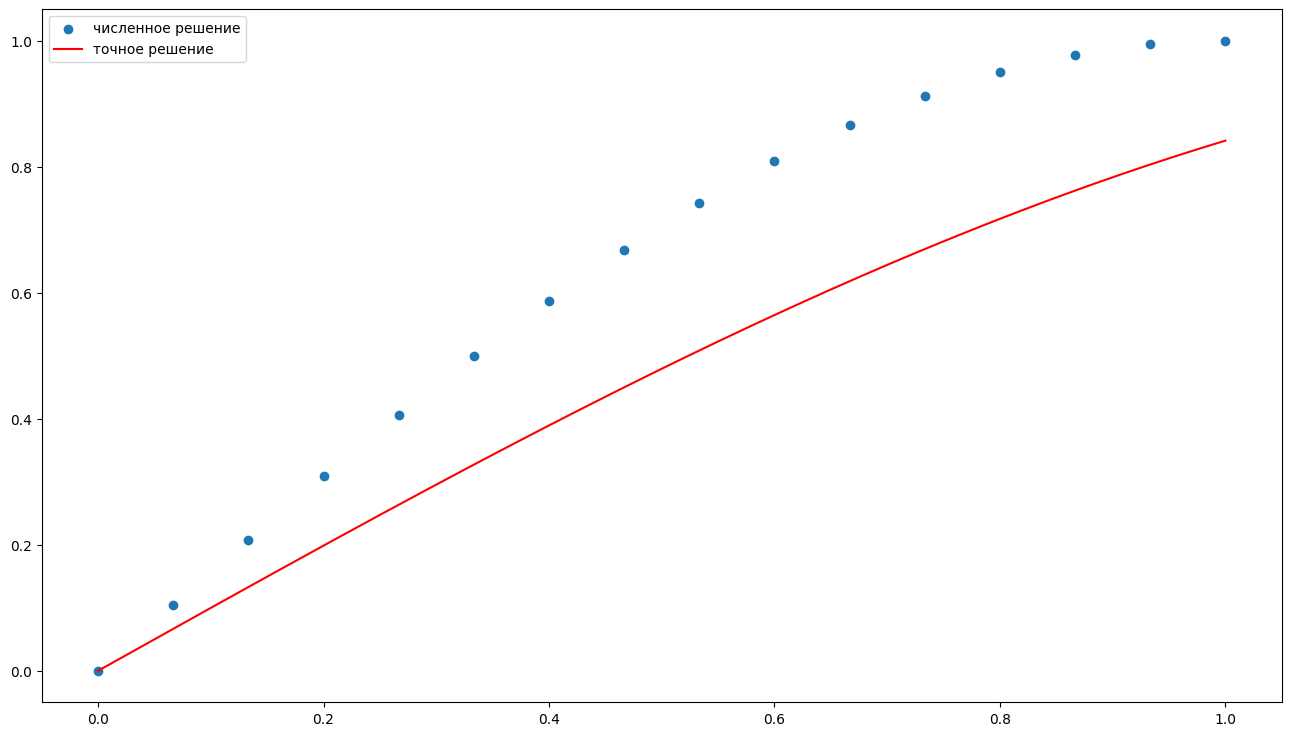

In [10]:
plot(segment, my_sin, np.sin)

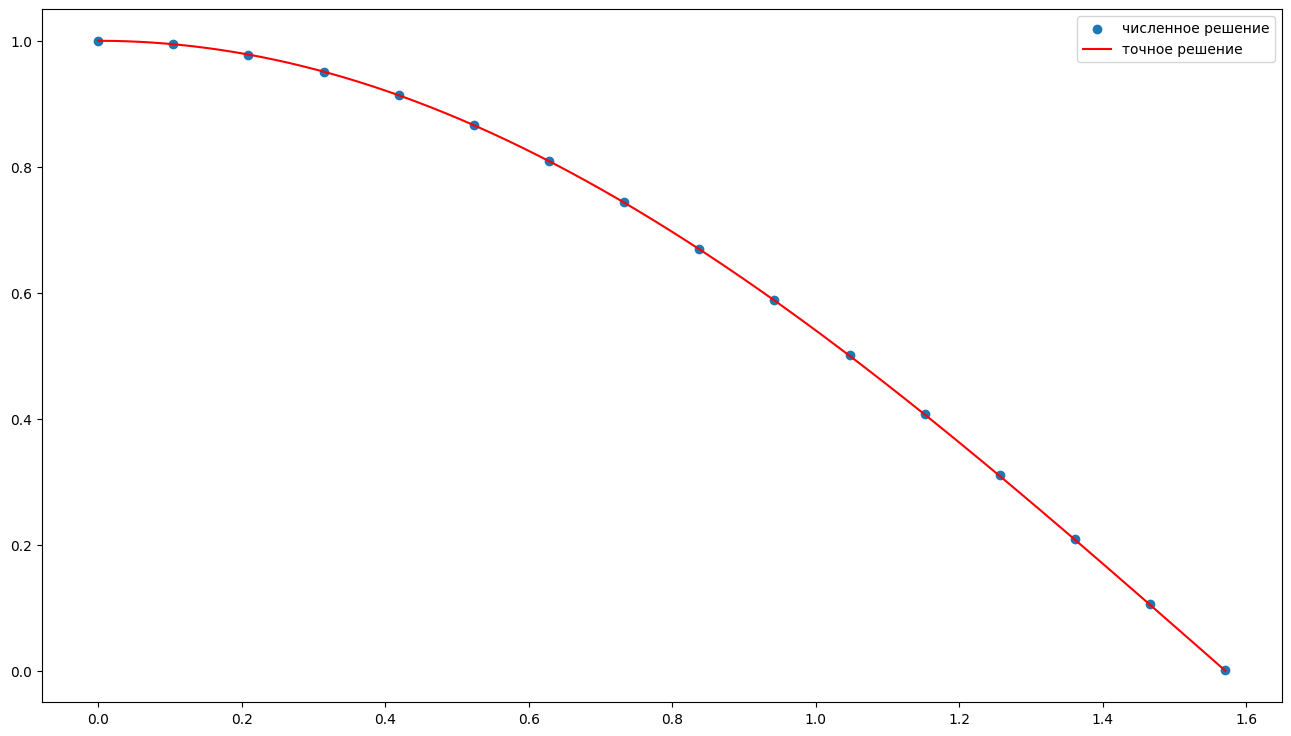

In [11]:
plot(segment2, my_cos, np.cos)

In [12]:
def plot_log_error(segment, u0, f, gradf, real_sol):
    ns = 5**(np.arange(8)+1)
    dim = len(real_sol)
    
    for i in range(dim):
        err = []
        for n in ns:
            t = make_arange(segment,n)
            sol = butcher_method(segment, u0, f, gradf, n, tol=1e-10)
            if dim > 1:
                my_sol = [sol[k][i] for k in range(n + 1)]
            else:
                my_sol = sol

            err.append(np.log(np.linalg.norm(my_sol - real_sol[i](t), ord=np.inf)))
            
        plt.figure(figsize=(14, 10))
        plt.plot(np.log(ns), err)
        plt.xlabel("Количество узлов сетки в лог. маштабе")
        plt.title("Численное решение " + str(real_sol[i]))
        plt.show()

[1 1.662180317675032 2.7539310924648257]
[1 1.2855031770859677 1.6520965130094514 2.1228116739235516
 2.7272219045575166]
[1 1.1333217783166767 1.2843951451763371 1.4555836971329585
 1.649565739965354 1.869376191723626 2.118454065101432 2.400696272012668
 2.720518592164302]
[1 1.064515451841183 1.1331917928407045 1.2062973772934484
 1.284117866859346 1.3669573467925191 1.455139514161019 1.5490089427001545
 1.6489324292418501 1.7553004269812384 1.8685285711810047
 1.9890593032752082 2.117363599718801 2.2539428123383596 2.399330627375244
 2.5540951508761824 2.718841128579994]
[1 1.0317459907421735 1.0644997074049385 1.0982931386428398
 1.1331592885393187 1.1691322088398863 1.2062470322084877
 1.2445400065395358 1.284048530359127 1.3248111893500114
 1.3668677940359906 1.4102594186625454 1.455028441311669
 1.5012185852900803 1.5488749618312405 1.5980441141528774
 1.6487740629130456 1.7011143531091164 1.7551161024655024
 1.8108320513573726 1.8683166143191166 1.927625933187863 1.988817931933

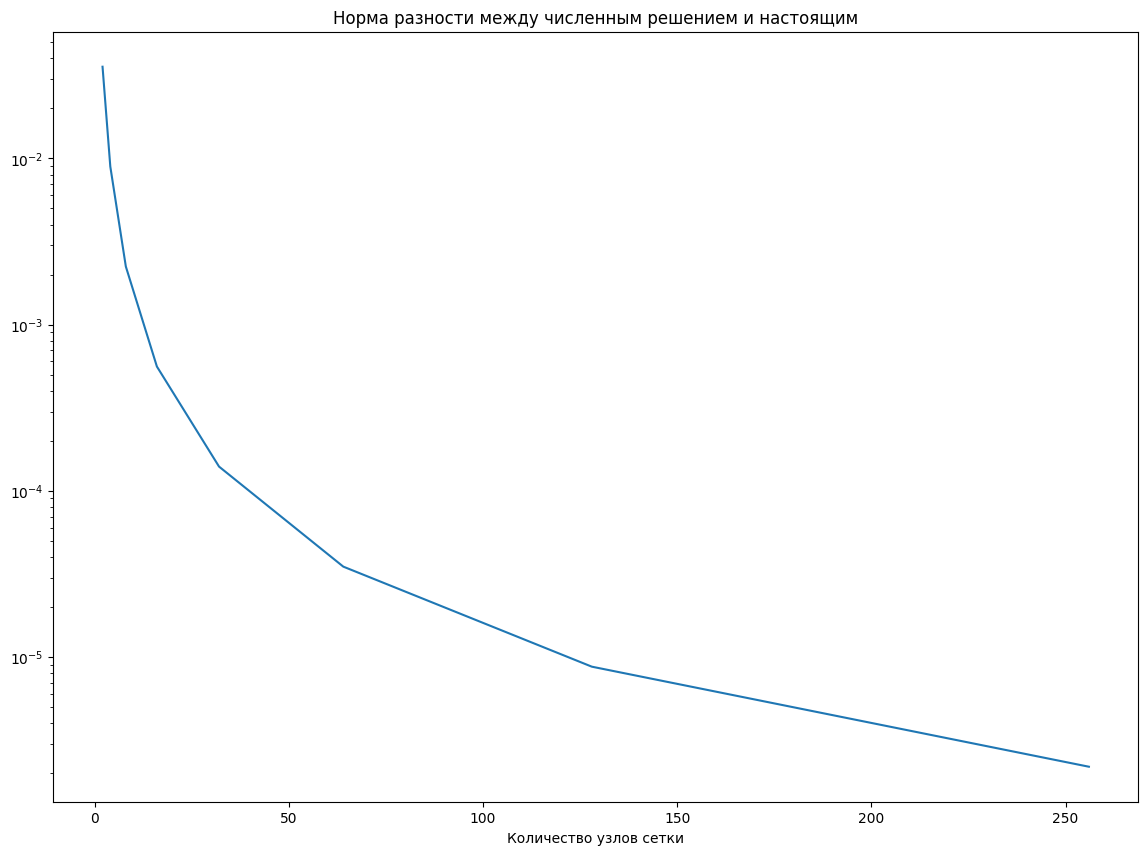

In [13]:
plot_error(segment, 1, f, gradf, [np.exp])

[0.0, 0.6804623209366398, 0.9972625390670163]
[0.0, 0.3781213168061624, 0.7000961956484593, 0.9181152648851715, 0.9998053320995542]
[0.0, 0.1944751339761265, 0.3815242148793218, 0.5540047542400799, 0.7053305648520813, 0.8297232550107754, 0.922432876997311, 0.9799193043226745, 0.9999874118232355]
[0.0, 0.09793877994285453, 0.19493586703455257, 0.2900586229111023, 0.38239243112288573, 0.47104949127904827, 0.5551773553523394, 0.6339671240668326, 0.7066612245592966, 0.7725606945310897, 0.8310319028526056, 0.8815126420008697, 0.9235175337507828, 0.9566426961436607, 0.9805696268596155, 0.9950682656547021, 0.9999992064171352]
[0.0, 0.049057833124589396, 0.0979975290631701, 0.14670123511834265, 0.19505166688484318, 0.24293239068455358, 0.29022810395285803, 0.3368249129011418, 0.382610606786787, 0.4274749281301905, 0.47130983822808886, 0.5140097773238014, 0.5554719188078711, 0.5955964168369566, 0.6342866467746797, 0.6714494378754173, 0.7069952976507076, 0.7408386273779681, 0.7728979282325571, 0

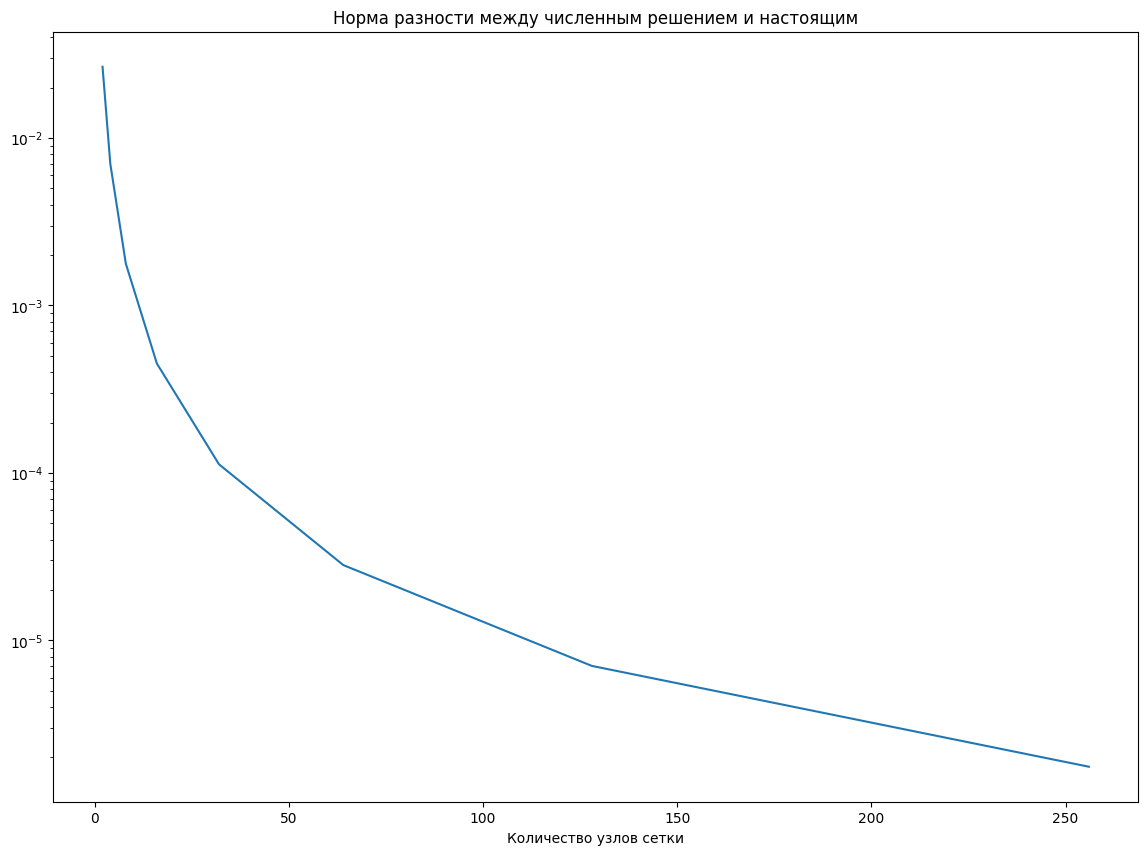

[1.0, 0.732783071437599, 0.07394205957104272]
[1.0, 0.9257560530597538, 0.7140485395535476, 0.3963134622805937, 0.019730633677108422]
[1.0, 0.9809074483685847, 0.9243588445299353, 0.8325135027609996, 0.7088785469214341, 0.5581749905668685, 0.38615746455877753, 0.19939447589079676, 0.0050175885708879375]
[1.0, 0.9951924413817185, 0.9808159907666102, 0.9570088794127852, 0.9240000154869744, 0.8821067830856703, 0.8317319905498298, 0.7733599974154528, 0.707552057239858, 0.6349409210829307, 0.5562247535314995, 0.4721604197649846, 0.3835562082079645, 0.2912640587422132, 0.1961713712048584, 0.0991924729349115, 0.0012598274087108202]
[1.0, 0.9987959396238653, 0.9951866580182399, 0.9891808467690592, 0.9807929685950263, 0.9700432225196398, 0.9569574952295055, 0.9415672987360691, 0.9239096944908882, 0.904027204137181, 0.8819677071125748, 0.8577843253496393, 0.831535295351858, 0.8032838279530954, 0.7730979560982765, 0.7410503710118402, 0.7072182471484934, 0.6716830563478046, 0.6345303716401769, 0.5

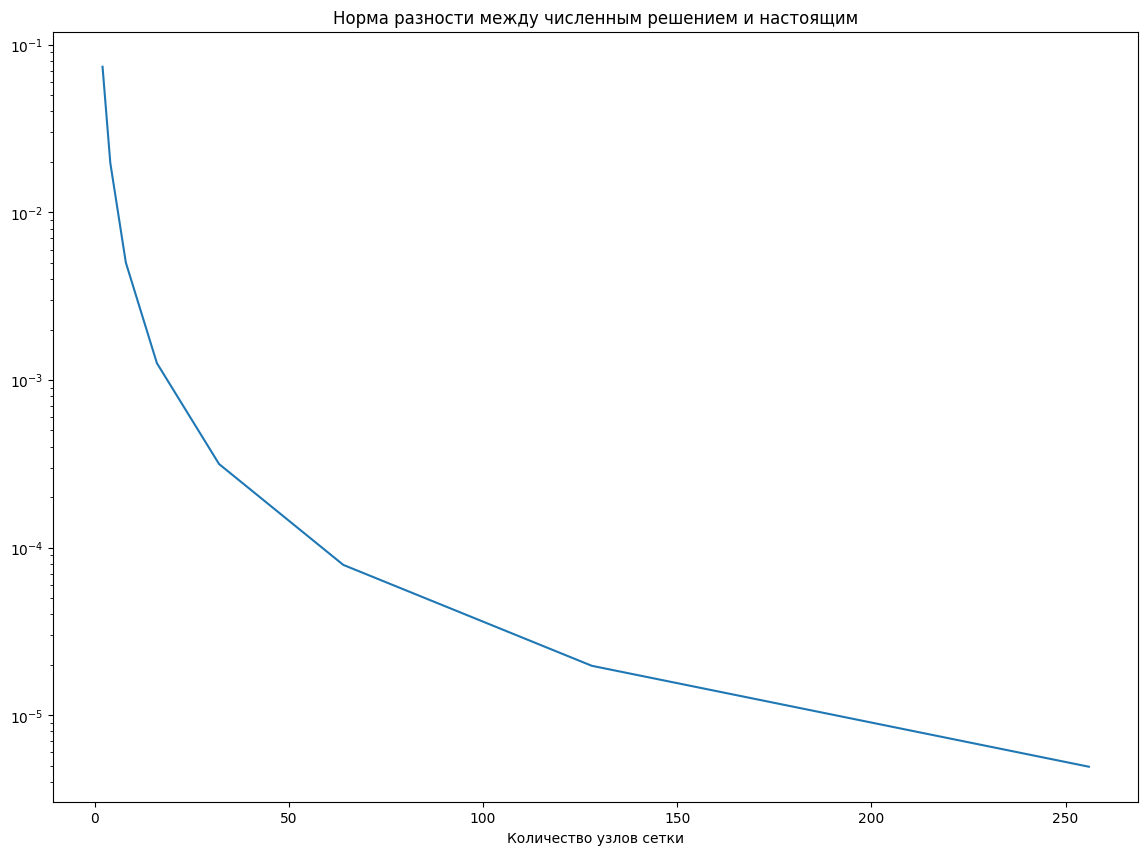

In [14]:
plot_error(segment2, np.array([0.,1.]), f2, gradf2, [np.sin, np.cos])

In [22]:
def plot_log_error(segment, u0, f, gradf, real_sol):
    ns = 5**(np.arange(8)+1)
    dim = len(real_sol)
    
    for i in range(dim):
        err = []
        for n in ns:
            t = make_arange(segment,n)
            sol = butcher_method(segment, u0, f, gradf, n, tol=1e-10)
            if dim > 1:
                my_sol = [sol[k][i] for k in range(n + 1)]
            else:
                my_sol = sol

            err.append(np.log(np.linalg.norm(my_sol - real_sol[i](t), ord=np.inf)))
            
        plt.figure(figsize=(14, 10))
        plt.plot(np.log(ns), err)
        plt.xlabel("Количество узлов сетки в лог. маштабе")
        plt.title("Численное решение " + str(real_sol[i]))
        plt.show()

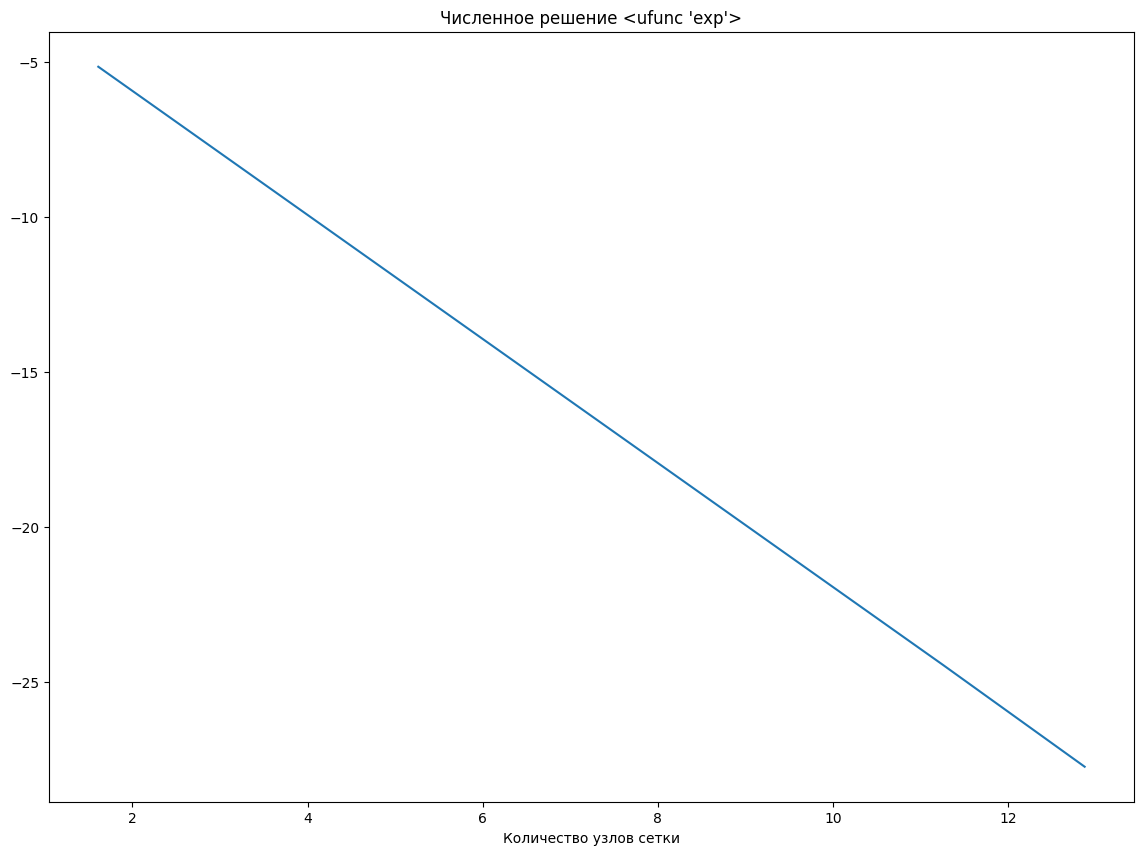

In [23]:
plot_log_error(segment, 1, f, gradf, [np.exp])

По наклону графика ошибки видим, что на одно деление вдоль оси x приходится примерно два деления вдоль оси y, т. е. порядок аппроксимации второй. Это согласуется с теоретическими результатами.